# Milestone 2

In [1]:
!pip install --quiet gensim
!pip install evaluate

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import os, zipfile , json , random, requests, unicodedata, re
from pathlib import Path
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import  Sequential
import string
from tensorflow.keras import layers
from tensorflow.keras.utils import serialize_keras_object, deserialize_keras_object
from tensorflow.keras.layers import Embedding
from collections import Counter
from collections import defaultdict
import evaluate
from datasets import load_dataset
from tqdm.auto import tqdm


## Helper functions

In [5]:
def _normalize(text: str) -> str:
    """Lower-case, strip punctuation & extra spaces."""
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)    # remove punctuation
    return " ".join(text.split())

In [57]:
def answer_from_ids(enc_ids, s, e, tok):
    return tok.sequences_to_texts([enc_ids[s:e+1]])[0].strip()

In [43]:
def normalize_text(text: str) -> str:
    """Lower-case, strip punctuation & collapse whitespace."""
    text = unicodedata.normalize("NFKC", text.lower())
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)
    return " ".join(text.split())

### Custom evaluation metrics

In [36]:
def _batch_em_f1(model, val_ds, tokenizer):
    em_total = 0.0
    f1_total = 0.0
    n_examples = 0

    for (enc, mask), (y_start, y_end) in val_ds:     # ← new label structure
        # forward
        start_logits, end_logits = model((enc, mask), training=False)
        pred_start = tf.argmax(start_logits, axis=-1).numpy()   # (B,)
        pred_end   = tf.argmax(end_logits,   axis=-1).numpy()   # (B,)

        enc_np      = enc.numpy()
        gold_start  = y_start.numpy()   # (B,)
        gold_end    = y_end.numpy()     # (B,)

        batch_size = enc_np.shape[0]
        for i in range(batch_size):
            # ---- texts ----
            pred_txt = tokenizer.sequences_to_texts(
                [enc_np[i, pred_start[i]:pred_end[i]+1]])[0]
            gold_txt = tokenizer.sequences_to_texts(
                [enc_np[i, gold_start[i]:gold_end[i]+1]])[0]

            pred_toks = _normalize(pred_txt).split()
            gold_toks = _normalize(gold_txt).split()


            em_total += int(pred_toks == gold_toks)


            if pred_toks and gold_toks:
                common = (
                    collections.Counter(pred_toks) &
                    collections.Counter(gold_toks)
                )
                overlap = sum(common.values())
                if overlap:
                    prec = overlap / len(pred_toks)
                    rec  = overlap / len(gold_toks)
                    f1_total += 2 * prec * rec / (prec + rec)

            n_examples += 1

    em = em_total / n_examples
    f1 = f1_total / n_examples
    return em, f1


### For directory work

In [7]:

def is_kaggle():
    return 'KAGGLE_URL_BASE' in os.environ

def is_colab():
    return (not is_kaggle()) and os.path.exists('/content')

def maybe_mount_drive():
    if is_colab():
        from google.colab import drive
        if not os.path.isdir('/content/drive'):
            drive.mount('/content/drive')


def get_data_path():
    if is_kaggle():
        return '/kaggle/input/squad-2-0/'
    elif is_colab():
        return '/content/drive/MyDrive/SQuAD'
    else:
        return './data/'
def get_model_dir():
    if is_colab():
        model_dir = '/content/drive/MyDrive/models'
    elif is_kaggle():
        model_dir = '/kaggle/working/models'
    else:
        model_dir = './models'
    os.makedirs(model_dir, exist_ok=True)
    return model_dir

## Explorting dataset:

In [8]:
dataset_dir = get_data_path()
maybe_mount_drive()
os.makedirs(dataset_dir, exist_ok=True)

Mounted at /content/drive


In [9]:
file_path = os.path.join(dataset_dir, 'train-v2.0.json')

In [10]:
with open(file_path, 'r', encoding='utf-8') as f:
    squad = json.load(f)

In [11]:
records = []
for article in squad['data']:
    for para in article['paragraphs']:
        ctx = para['context']
        for qa in para['qas']:
            answers = [a['text'] for a in qa.get('answers', [])]
            starts  = [a['answer_start'] for a in qa.get('answers', [])]
            ends    = [s + len(t) for s,t in zip(starts, answers)]
            records.append({
                'question': qa['question'],
                'answers': answers,
                'context': ctx,
                'answer_start': starts,
                'answer_end': ends
            })



In [12]:
df = pd.DataFrame(records)
df.head()

,question,answers,context,answer_start,answer_end
0,When did Beyonce start becoming popular?,[in the late 1990s],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,[269],[286]
1,What areas did Beyonce compete in when she was...,[singing and dancing],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,[207],[226]
2,When did Beyonce leave Destiny's Child and bec...,[2003],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,[526],[530]
3,In what city and state did Beyonce grow up?,"[Houston, Texas]",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,[166],[180]
4,In which decade did Beyonce become famous?,[late 1990s],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,[276],[286]


In [13]:
print("Total QA pairs:", len(df))

Total QA pairs: 130319


## Data Cleaning

Dropping rows where answers are empty

In [14]:
df = df[df['answers'].map(len) > 0].reset_index(drop=True)
print("Rows remaining after drop:", len(df))

Rows remaining after drop: 86821


In [15]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df_subset = df.head(10000).copy().reset_index(drop=True)

print("Subset size:", df_subset.shape)
df_subset.head()

Subset size: (10000, 5)


,question,answers,context,answer_start,answer_end
0,"After cellulose, what component is most plenti...",[hemicellulose],"Aside from water, wood has three main componen...",[152],[165]
1,How much of the Bronx's vote in 1916 did Hughe...,[42.6%],"Since then, the Bronx has always supported the...",[602],[607]
2,When did Homo sapiens begin using subsistence ...,[0.2 million years ago],Hunting and gathering was presumably the subsi...,[174],[195]
3,When did she say the she is a feminist?,[April 2013],In an interview published by Vogue in April 20...,[38],[48]
4,"Along with Somalo-Islamic architecture, what i...",[Western designs],Somali architecture is a rich and diverse trad...,[500],[515]


Removing Extra Whitespaces

In [16]:
def collapse_whitespace(s):
    if isinstance(s, str):
        return re.sub(r'\s+', ' ', s.strip())
    return s

In [17]:
for col in ['question', 'context', 'answers']:
    if col in df_subset.columns:
        df_subset[col] = df_subset[col].apply(collapse_whitespace)

**Lets explore the length of the sequences which will determine some hyperparameters in training the models**

In [18]:
df_subset['question'].str.len().max()

270

In [19]:
df_subset['context'].str.len().max()

3076

We just turn the array of the answers to a string since none have multiple answers

In [20]:
# df_subset['answers']= df_subset['answers'].apply(lambda x: x[0])

In [21]:
df_subset['answers'].str.len().max()

1

## Embeddings

**Tokenizer**

In [22]:

def truncate_context(context: str, ans_start: int, ans_end: int, max_len: int):
    """
    Return (substring, start_index) of length up to max_len characters,
    centered on [ans_start:ans_end], cut at word boundaries.
    """
    ans_len = ans_end - ans_start
    extra   = max_len - ans_len
    pre     = extra // 2
    post    = extra - pre

    start = ans_start - pre
    end   = ans_end   + post

    if start < 0:
        start = 0
        end   = min(max_len, len(context))
    if end > len(context):
        end   = len(context)
        start = max(0, len(context) - max_len)

    if start > 0 and not context[start].isspace():
        m = re.search(r'\s', context[:start][::-1])
        if m:
            start -= m.start()
    if end < len(context) and not context[end].isspace():
        m = re.search(r'\s', context[end:])
        if m:
            end += m.start()

    return context[start:end], start


In [23]:
MAX_CTX_CHARS = 450

def truncate_row(row, max_len=MAX_CTX_CHARS):
    ctx = row.context
    s, e = row.answer_start[0], row.answer_end[0]
    ctx_t, base = truncate_context(ctx, s, e, max_len)

    row['ctx_trunc']     = ctx_t
    row['ans_start_ofs'] = s - base
    row['ans_end_ofs']   = e - base
    return row

df_proc = df_subset.apply(truncate_row, axis=1)


In [24]:
SPECIAL = ["[PAD]", "[UNK]", "[BOS]", "[EOS]", "[SEP]"]

tok = Tokenizer(
        lower=False,
        oov_token="[UNK]",
        filters='''!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n''',
        num_words=None)

tok.fit_on_texts(SPECIAL
                 + df_proc.question.tolist()
                 + df_proc.answers.str[0].tolist()
                 + df_proc.ctx_trunc.tolist())

PAD = tok.word_index["[PAD]"] = 0
BOS = tok.word_index["[BOS]"]
EOS = tok.word_index["[EOS]"]
SEP = tok.word_index["[SEP]"]

print({"PAD":PAD, "BOS":BOS, "EOS":EOS, "SEP":SEP})


{'PAD': 0, 'BOS': 32528, 'EOS': 32529, 'SEP': 32530}


In [25]:
MAX_TOK  = 512
SEP_ID   = tok.word_index["[SEP]"]
PAD_ID   = tok.word_index["[PAD]"]

def char_to_token_span(ctx, char_s, char_e):
    """
    Map answer’s character offsets to (start_tok, end_tok) inside ctx.
    Uses regex-based tokenization so punctuation and single chars are handled.
    """
    tokens = [(m.group(), m.start(), m.end())
              for m in re.finditer(r"\S+", ctx)]
    start_tok = end_tok = None
    for idx, (_, ts, te) in enumerate(tokens):
        if ts <= char_s < te:
            start_tok = idx
        if ts < char_e <= te:
            end_tok = idx
    return start_tok, end_tok

def encode_row(row, i):
    q_ids = tok.texts_to_sequences([row.question])[0]
    c_ids = tok.texts_to_sequences([row.ctx_trunc])[0]

    char_s = row.ans_start_ofs
    char_e = row.ans_end_ofs
    answer_text = row.answers[0].strip()

    snippet = row.ctx_trunc[char_s:char_e]
    if snippet.strip() != answer_text:
        ctx_norm = unicodedata.normalize("NFKC", row.ctx_trunc) \
                   .replace("\u2013", "-").replace("\u2014", "-")
        ans_norm = unicodedata.normalize("NFKC", answer_text) \
                   .replace("\u2013", "-").replace("\u2014", "-")

        found = ctx_norm.find(ans_norm)
        if found != -1:
            char_s, char_e = found, found + len(ans_norm)
        else:
            m = re.search(re.escape(ans_norm), ctx_norm)
            if m:
                char_s, char_e = m.start(), m.end()
            else:
                first3 = " ".join(answer_text.split()[:3])
                found = row.ctx_trunc.find(first3)
                if found != -1:
                    char_s, char_e = found, found + len(first3)
                else:
                    raise ValueError(f"Could not locate answer in row {i}.")

    s_tok, e_tok = char_to_token_span(row.ctx_trunc, char_s, char_e)
    if s_tok is None or e_tok is None:
        raise ValueError(f"Token span not found after fallback for row {i}!")

    enc = q_ids + [SEP_ID] + c_ids
    shift = len(q_ids) + 1
    s_tok += shift; e_tok += shift

    if len(enc) > MAX_TOK:
        enc = enc[:MAX_TOK]
        s_tok = min(s_tok, MAX_TOK-1)
        e_tok = min(e_tok, MAX_TOK-1)
    enc += [PAD_ID] * (MAX_TOK - len(enc))

    return enc, (s_tok, e_tok)

encoded, spans = [], []
for i, r in df_proc.iterrows():
    enc, sp = encode_row(r, i)
    encoded.append(enc); spans.append(sp)

enc_arr  = np.asarray(encoded, dtype="int32")
span_arr = np.asarray(spans,   dtype="int32")


**Load gloVe dictionary**

In [26]:
def prepare_glove(target_dim=100, work_subdir='glove',
                  input_dataset_slug='glove6b',
                  download_url='http://nlp.stanford.edu/data/glove.6B.zip'):
    maybe_mount_drive()

    if is_kaggle():
        work_dir = f'/kaggle/working/{work_subdir}'
        uploaded_zip = f'/kaggle/input/{input_dataset_slug}/glove.6B.zip'
    elif is_colab():
        work_dir = f'/content/drive/MyDrive/{work_subdir}'
        uploaded_zip = None
    else:
        work_dir = f'./data/{work_subdir}'
        uploaded_zip = None

    os.makedirs(work_dir, exist_ok=True)

    target_file = f'glove.6B.{target_dim}d.txt'
    txt_path = os.path.join(work_dir, target_file)
    zip_path = os.path.join(work_dir, os.path.basename(download_url))

    if os.path.exists(txt_path):
        return txt_path

    if is_kaggle() and uploaded_zip and os.path.exists(uploaded_zip):
        zip_path = uploaded_zip
    else:
        if requests is None:
            raise RuntimeError("`requests` not available; offline mode")
        with requests.get(download_url, stream=True) as r, open(zip_path, 'wb') as f:
            r.raise_for_status()
            for chunk in r.iter_content(8192):
                f.write(chunk)

    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extract(target_file, path=work_dir)

    if not os.path.exists(txt_path):
        raise RuntimeError(f"Failed to extract {target_file}")

    return txt_path

glove_path = prepare_glove()
print("GloVe file:", glove_path)

GloVe file: /content/drive/MyDrive/glove/glove.6B.100d.txt


In [27]:
def create_embedding_layer(
    tokenizer,
    glove_path: str,
    embedding_dim: int,
    mask_zero: bool = True,
    trainable: bool = False,
    oov_token: str = '[UNK]'
) -> Embedding:
    """
    Build a Keras Embedding layer from a fitted tokenizer and a GloVe file.

    Args:
        tokenizer: a fitted keras.preprocessing.text.Tokenizer
        glove_path: path to a GloVe‑style file (word + embedding_dim floats)
        max_num_words: max vocabulary size (typically tokenizer.num_words)
        embedding_dim: dimensionality of the GloVe vectors
        mask_zero: if True, reserve index 0 for padding (and mask it)
        trainable: if False, freeze the embedding weights
        oov_token: the out‑of‑vocab token (must match tokenizer.oov_token)

    Returns:
        A tf.keras.layers.Embedding instance with pretrained weights.
    """

    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            coefs = np.asarray(parts[1:], dtype='float32')
            if coefs.shape[0] != embedding_dim:
                continue
            embeddings_index[word] = coefs


    vocab_size =  len(tokenizer.word_index) + 1
    embedding_matrix = np.random.normal(
        scale=0.01,
        size=(vocab_size, embedding_dim)
    ).astype('float32')


    for word, idx in tokenizer.word_index.items():
        if idx == 0 or idx >= vocab_size:
            continue
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        mask_zero=mask_zero,
        trainable=trainable,
        name='pretrained_embedding'
    )
    return embedding_layer

In [28]:
EMB_DIM      = 100
GLOVE_PATH   = prepare_glove()

embedding_layer = create_embedding_layer(
    tokenizer=tok,
    glove_path=GLOVE_PATH,
    embedding_dim=EMB_DIM,
    mask_zero=False,
    trainable=False
)

## Building the model

In [29]:
answer_len_bucket = np.clip((span_arr[:,1] - span_arr[:,0]), 0, 30) // 5
enc_tr, enc_val, span_tr, span_val = train_test_split(
    enc_arr, span_arr,
    test_size=0.10,
    random_state=42,
    stratify=answer_len_bucket
)

def make_ds(enc, span, batch=64):
    ds = tf.data.Dataset.from_tensor_slices((enc, (span[:, 0], span[:, 1])))

    def add_mask(x, y):
        y_start, y_end = y           # unpack the tuple
        mask = tf.cast(x != PAD_ID, tf.int32)
        return (x, mask), (y_start, y_end)

    return (ds.shuffle(2000)
              .map(add_mask, tf.data.AUTOTUNE)
              .batch(batch)
              .prefetch(tf.data.AUTOTUNE))



train_ds = make_ds(enc_tr, span_tr, batch=64)

val_ds   = make_ds(enc_val, span_val, batch=64)

In [30]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, max_len: int, embed_dim: int, **kwargs):
        super().__init__(**kwargs)
        # self.supports_masking = True
        self.max_len   = max_len
        self.embed_dim = embed_dim

        pos = np.arange(max_len)[:, np.newaxis]
        dim = np.arange(embed_dim)[np.newaxis, :]
        angle_rates = 1.0 / np.power(10000.0, (2 * (dim//2)) / embed_dim)
        angle_rads  = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)


    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

    def get_config(self):
        config = super().get_config()
        config.update({
            "max_len": self.max_len,
            "embed_dim": self.embed_dim,
        })
        return config

In [31]:
class Encoder(layers.Layer):
    def __init__(self,embed_dim: int, num_heads: int, ff_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim    = ff_dim
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.layer1 = layers.LayerNormalization()
        self.layer2 = layers.LayerNormalization()
        self.ffn =  tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])


    def call(self,pos_matrix, padding_mask, training=False, **kwargs):
        att_out= self.attention(query=pos_matrix, value=pos_matrix, key=pos_matrix,attention_mask=padding_mask)
        norm1 = self.layer1(att_out+pos_matrix)
        ff_out = self.ffn(norm1, training=training)
        return self.layer2(norm1 + ff_out, training=training)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
        })
        return config



In [32]:
class SpanQA(tf.keras.Model):
    def __init__(
        self,
        vocab_size: int = None,
        embedding_dim: int = 100,
        embedding_layer: tf.keras.layers.Layer = None,
        num_heads: int = 4,
        ff_dim: int = 512,
        max_len: int = 512,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.vocab_size    = vocab_size
        self.embedding_dim = embedding_dim
        self.num_heads     = num_heads
        self.ff_dim        = ff_dim
        self.max_len       = max_len

        # ------------------ Embedding ------------------
        if embedding_layer is not None:
            self.emb = embedding_layer
            self.embedding_dim = embedding_layer.output_dim
        else:
            if vocab_size is None:
                raise ValueError(
                    "`vocab_size` must be set when no `embedding_layer` is given."
                )
            self.emb = layers.Embedding(
                vocab_size, embedding_dim, mask_zero=True, name="tok_emb"
            )


        self.pos  = PositionalEmbedding(max_len, self.embedding_dim, name="pos_emb")
        self.enc1 = Encoder(self.embedding_dim, num_heads, ff_dim, name="enc_block_1")
        self.enc2 = Encoder(self.embedding_dim, num_heads, ff_dim, name="enc_block_2")
        self.enc3 = Encoder(self.embedding_dim, num_heads, ff_dim, name="enc_block_3")  # NEW

        self.start = layers.Dense(1, name="start_head")
        self.end   = layers.Dense(1, name="end_head")


    def call(self, inputs, training=False):
        tok, mask1d = inputs
        x = self.pos(self.emb(tok))
        mask4d = mask1d[:, None, None, :]

        x = self.enc1(x, padding_mask=mask4d, training=training)
        x = self.enc2(x, padding_mask=mask4d, training=training)
        x = self.enc3(x, padding_mask=mask4d, training=training)  # NEW

        s = tf.squeeze(self.start(x), -1)
        e = tf.squeeze(self.end(x),   -1)
        return [s, e]


    def get_config(self):
        cfg = super().get_config()
        cfg.update(
            {
                "vocab_size":    self.vocab_size,
                "embedding_dim": self.embedding_dim,
                "num_heads":     self.num_heads,
                "ff_dim":        self.ff_dim,
                "max_len":       self.max_len,
                "embedding_layer": serialize_keras_object(self.emb),
            }
        )
        return cfg

    @classmethod
    def from_config(cls, cfg):
        emb_cfg = cfg.pop("embedding_layer")
        embedding_layer = deserialize_keras_object(
            emb_cfg, module_objects=globals(), custom_objects=None
        )
        return cls(embedding_layer=embedding_layer, **cfg)


In [60]:
model = SpanQA(
    embedding_layer=embedding_layer,  # or vocab_size=...
    num_heads=8,
    ff_dim=1024,
    max_len=MAX_TOK
)

dummy_tok  = tf.zeros((1, MAX_TOK), dtype="int32")
dummy_mask = tf.ones ((1, MAX_TOK), dtype="int32")
_ = model((dummy_tok, dummy_mask))
model.summary()


Model: "span_qa_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ pretrained_embedding            │ ?                      │     5,216,600 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pos_emb (PositionalEmbedding)   │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_block_1 (Encoder)           │ ?                      │       528,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_block_2 (Encoder)           │ ?                      │       528,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_block_3 (Encoder)           │ ?                      │       528,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ start_head (Dense)              │ (1, 512, 1)            │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ end_head (Dense)                │ (1, 512, 1)            │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,803,274 (25.95 MB)

 Trainable params: 1,586,674 (6.05 MB)

 Non-trainable params: 5,216,600 (19.90 MB)

## Model training

In [34]:
import re, numpy as np, tensorflow as tf, collections
class SpanMetrics(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, tokenizer):
        super().__init__()
        self.val_ds = val_ds
        self.tok    = tokenizer

    def on_epoch_end(self, epoch, logs=None):
        em, f1 = _batch_em_f1(self.model, self.val_ds, self.tok)
        logs = logs or {}
        logs["val_em"]  = em * 100
        logs["val_f1"]  = f1 * 100
        print(f"\n ➤ val_EM {em*100:.2f}%   val_F1 {f1*100:.2f}%\n")


In [61]:

metrics_cb = SpanMetrics(val_ds, tok)

ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_spanqa.keras",
    monitor="val_f1",
    mode="max",
    save_best_only=True,
    save_weights_only=False
)


loss_tok = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# def span_loss(y_true, y_pred):
#     s_true, e_true = y_true[:,0], y_true[:,1]
#     return (loss_tok(s_true, y_pred["start"]) +
#             loss_tok(e_true, y_pred["end"]))

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4, clipnorm=1.0),
    loss=[loss_tok, loss_tok]
)


model.fit(
    train_ds,
    epochs=8,
    validation_data=val_ds,
    callbacks=[metrics_cb, ckpt_cb]
)


Epoch 1/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - loss: 8.5621 - sparse_categorical_crossentropy_loss: 4.2650
 ➤ val_EM 3.40%   val_F1 12.63%

141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 459ms/step - loss: 8.5591 - sparse_categorical_crossentropy_loss: 4.2632 - val_loss: 7.8049 - val_sparse_categorical_crossentropy_loss: 3.8447 - val_em: 3.4000 - val_f1: 12.6252
Epoch 2/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 7.7896 - sparse_categorical_crossentropy_loss: 3.8309
 ➤ val_EM 4.70%   val_F1 15.61%

141/141 ━━━━━━━━━━━━━━━━━━━━ 68s 405ms/step - loss: 7.7891 - sparse_categorical_crossentropy_loss: 3.8307 - val_loss: 7.7304 - val_sparse_categorical_crossentropy_loss: 3.8203 - val_em: 4.7000 - val_f1: 15.6063
Epoch 3/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 7.6011 - sparse_categorical_crossentropy_loss: 3.7368
 ➤ val_EM 4.50%   val_F1 15.69%

141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 410ms/step - loss: 7.6008 - sparse_categorical_crossentropy_loss: 3.7367 - val_loss: 7.5543 - val_spa

KeyboardInterrupt: 

In [38]:
prev_epochs = len(model.history.history.get("loss", []))

history_add = model.fit(
    train_ds,
    initial_epoch=prev_epochs,
    epochs=prev_epochs + 30,
    validation_data=val_ds,
    callbacks=[metrics_cb, ckpt_cb],
    verbose=1
).history

Epoch 21/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 1.3691 - sparse_categorical_crossentropy_loss: 0.6354
 ➤ val_EM 2.70%   val_F1 12.96%

141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 393ms/step - loss: 1.3689 - sparse_categorical_crossentropy_loss: 0.6354 - val_loss: 16.5165 - val_sparse_categorical_crossentropy_loss: 8.1863 - val_em: 2.7000 - val_f1: 12.9568
Epoch 22/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 1.2009 - sparse_categorical_crossentropy_loss: 0.5612
 ➤ val_EM 2.40%   val_F1 10.70%

141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 392ms/step - loss: 1.2009 - sparse_categorical_crossentropy_loss: 0.5612 - val_loss: 17.6184 - val_sparse_categorical_crossentropy_loss: 8.8015 - val_em: 2.4000 - val_f1: 10.6997
Epoch 23/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 1.0993 - sparse_categorical_crossentropy_loss: 0.5266
 ➤ val_EM 2.60%   val_F1 11.26%

141/141 ━━━━━━━━━━━━━━━━━━━━ 84s 408ms/step - loss: 1.0991 - sparse_categorical_crossentropy_loss: 0.5264 - val_loss: 18.3615 

In [40]:
combined = defaultdict(list)

for k, v in model.history.history.items():
    combined[k].extend(v)

for k, v in history_add.items():
    combined[k].extend(v)

model.history.history = combined

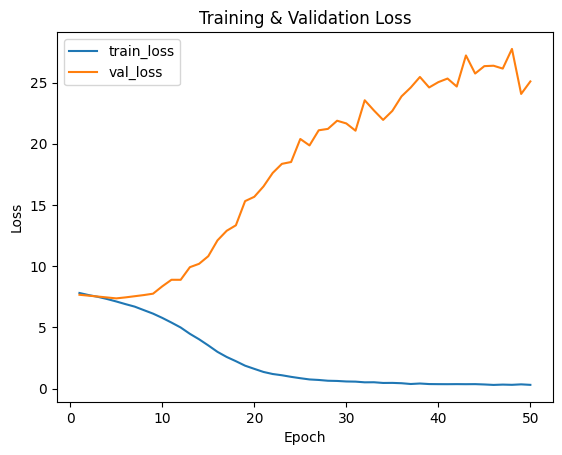

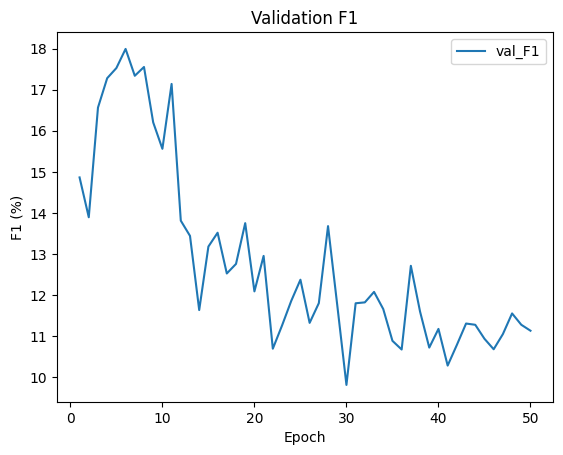

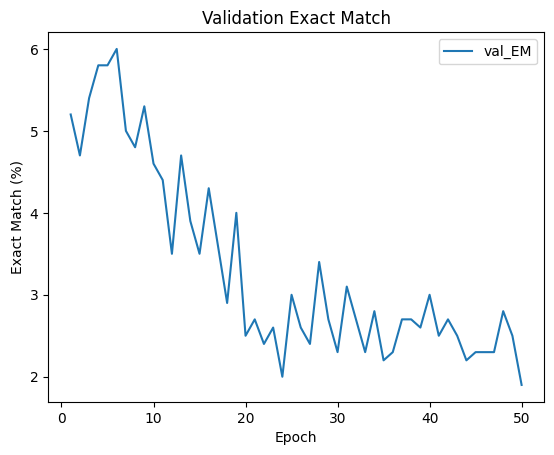

In [54]:
epochs = range(1, len(combined["loss"]) + 1)

plt.figure()
plt.plot(epochs, combined["loss"], label="train_loss")
plt.plot(epochs, combined["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

if "val_f1" in combined:
    plt.figure()
    plt.plot(epochs, combined["val_f1"], label="val_F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 (%)")
    plt.title("Validation F1")
    plt.legend()
    plt.show()

if "val_em" in combined:
    plt.figure()
    plt.plot(epochs, combined["val_em"], label="val_EM")
    plt.xlabel("Epoch")
    plt.ylabel("Exact Match (%)")
    plt.title("Validation Exact Match")
    plt.legend()
    plt.show()

## Post Processing

In [62]:
def answer_span(
    model,
    question: str,
    context: str,
    tokenizer,
    max_tok: int,
    sep_id: int,
    pad_id: int,
):
    """
    Predict the answer span inside `context` for `question`.
    Returns the extracted answer string.
    """
    q_ids = tokenizer.texts_to_sequences([question])[0]
    c_ids = tokenizer.texts_to_sequences([context])[0]

    enc = q_ids + [sep_id] + c_ids
    if len(enc) > max_tok:
        enc = enc[:max_tok]

    enc_padded = enc + [pad_id] * (max_tok - len(enc))
    mask       = [1] * len(enc) + [0] * (max_tok - len(enc))

    enc_tensor  = tf.constant([enc_padded], dtype=tf.int32)  # (1, L)
    mask_tensor = tf.constant([mask],       dtype=tf.int32)  # (1, L)

    start_logits, end_logits = model((enc_tensor, mask_tensor), training=False)
    start_idx = int(tf.argmax(start_logits[0]).numpy())
    end_idx   = int(tf.argmax(end_logits[0]).numpy())

    if end_idx < start_idx:
        end_idx = start_idx

    answer_tokens = enc_padded[start_idx : end_idx + 1]
    answer = tokenizer.sequences_to_texts([answer_tokens])[0].strip()

    return answer

In [ ]:
SEP_ID = tok.word_index["[SEP]"]
PAD_ID = tok.word_index["[PAD]"]

q  = "what is my name ?"
ctx= "Hello everyone. I am ahmed labib and I am 23 years old."
print(answer_span(model, q, ctx, tok, MAX_TOK, SEP_ID, PAD_ID))





23


In [ ]:
q = "What do I love?"
ctx = "I love Pizaa and I want to bulk."
print(answer_span(model, q, ctx, tok, MAX_TOK, SEP_ID, PAD_ID))

I want to go to it's


## Inference using the best model

In [52]:
dev_ds = load_dataset("squad_v2", split="validation")
metric = evaluate.load("squad_v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [55]:

def evaluate_spanqa(model, tok, max_tok, sep_id, pad_id):
    dev_ds  = load_dataset("squad_v2", split="validation")
    metric  = evaluate.load("squad_v2")

    preds, refs = [], []

    for ex in tqdm(dev_ds, desc="evaluating"):
        q_ids = tok.texts_to_sequences([ex["question"]])[0]
        c_ids = tok.texts_to_sequences([ex["context"]])[0]

        enc = q_ids + [sep_id] + c_ids
        if len(enc) > max_tok:
            enc = enc[:max_tok]
        enc_pad = enc + [pad_id] * (max_tok - len(enc))
        mask    = [1]*len(enc) + [0]*(max_tok-len(enc))

        s_log, e_log = model(
            (tf.constant([enc_pad]), tf.constant([mask])),
            training=False
        )
        s_idx = int(tf.argmax(s_log[0]));  e_idx = int(tf.argmax(e_log[0]))
        if e_idx < s_idx:
            e_idx = s_idx

        pred_text = answer_from_ids(enc_pad, s_idx, e_idx, tok)

        preds.append({
            "id": ex["id"],
            "prediction_text": pred_text,
            "no_answer_probability": 0.0
        })
        refs.append({
            "id": ex["id"],
            "answers": ex["answers"]
        })

    return metric.compute(predictions=preds, references=refs)





In [71]:
results = evaluate_spanqa(model,
                          tok=tok,
                          max_tok=MAX_TOK,
                          sep_id=SEP_ID,
                          pad_id=PAD_ID)

print(f"Exact-Match: {results['exact']:.2f}")
print(f"F1         : {results['f1']:.2f}")

evaluating:   0%|          | 0/11873 [00:00<?, ?it/s]

Exact-Match: 2.06
F1         : 4.45
